# Project - Sweet Lift Taxi

## Table of Contents

* [Project description](#Project_description)
* [Data description](#Data_description)
* [Import Libraries and Preprocess the Data](#Libraries)
* [Resample it by one hour](#resample)
* [EDA](#EDA)
* [Train different models with various hyperparameters](#train)
    * [Features engineering](#engineering)
    * [Split the data](#split)
    * [Scaling the features](#scaling)
    * [Training different models](#models)
        * [Linear regression](#linearregression)
        * [Random Forest Regressor](#randomforest)
        * [Catboost regressor](#Catboost)
        * [LightGBM regressor](#LightGBM)
* [Conclusion](#conclusion)

## Project description <a class="anchor" id="Project_description"></a>

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour.
We will Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Data description <a class="anchor" id="Data_description"></a>


**Features:**
* Date

**Target:**
* Number of taxi orders

<div style="border:solid black 2px; padding: 20px"> <b>Note:</b><br>
We will  create features to make the forecasts

## Import Libraries and Preprocess the Data <a class="anchor" id="Libraries"></a>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.preprocessing import StandardScaler
import time
from statistics import mean
import catboost as cb
from sklearn.preprocessing import OrdinalEncoder
from catboost import Pool, cv
import math
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import calendar

import datetime


warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
plt.rc('figure', figsize =(18,3))
plt.rcParams['figure.facecolor'] = 'w'
pd.set_option('display.float_format', lambda x: '%.2f' %x)
pd.options.display.max_rows= 30

In [3]:
#Import the data
try:
    data = pd.read_csv('taxi.csv',parse_dates = ['datetime'], index_col = 'datetime')
    
except:
    print("Something went wrong when opening the file")

In [4]:
data.sort_index(inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Resample it by one hour <a class="anchor" id="resample"></a>

In [7]:
# Resample it by one hour 
data = data.resample('1H').sum()

In [8]:
#checking the resample
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [12]:
data.describe()

,num_orders
count,4416.00
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


## EDA

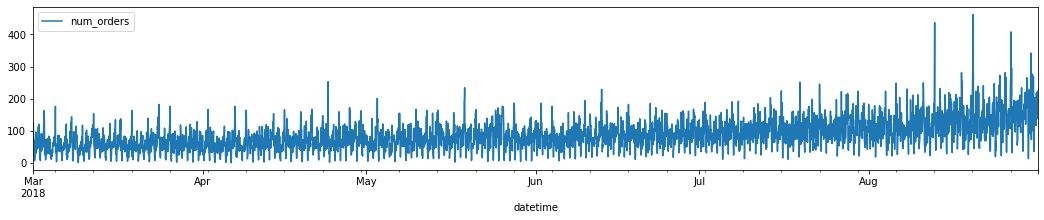

In [13]:
#plot the number of orders per hourfor all the data
data.plot();

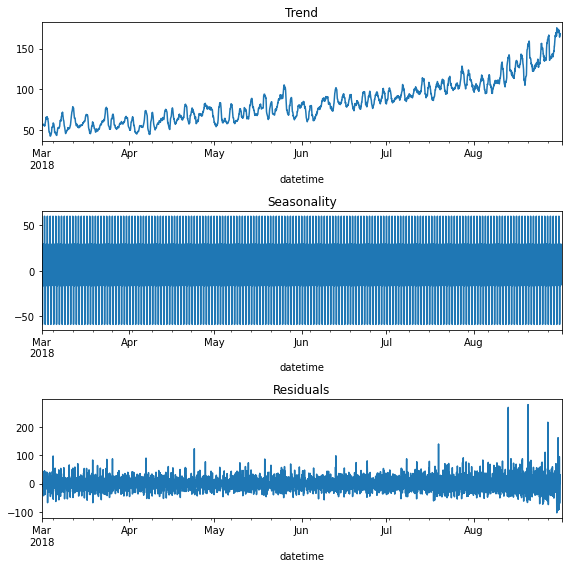

In [14]:
#Plot decomposed 
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')


# plt.subplot(x,y,z) says that the images make a table
# of x rows and y columns.
# z is the place of the current image.

# plt.subplot(311) says 3 rows, 1 column, first image. 

plt.tight_layout()    # this helps fit subplots into the area

In [15]:
values = pd.DataFrame(data.num_orders.values)
width =3
shifted = values.shift(width-1)
window = shifted.rolling(window=width)

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns =['min','mean','max','t+1']

In [16]:
df.head()

,min,mean,max,t+1
0,NaN,NaN,NaN,124
1,NaN,NaN,NaN,85
2,NaN,NaN,NaN,71
3,NaN,NaN,NaN,66
4,71.00,93.33,124.00,43


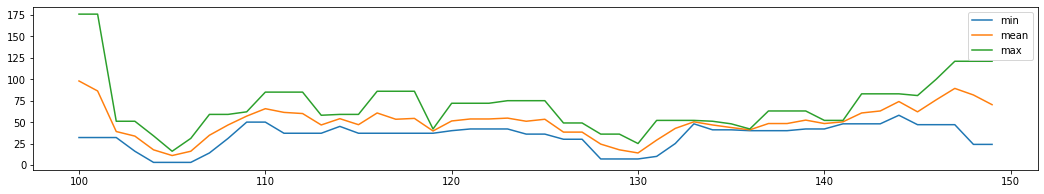

In [17]:
df[['min','mean','max']].iloc[100:150].plot();

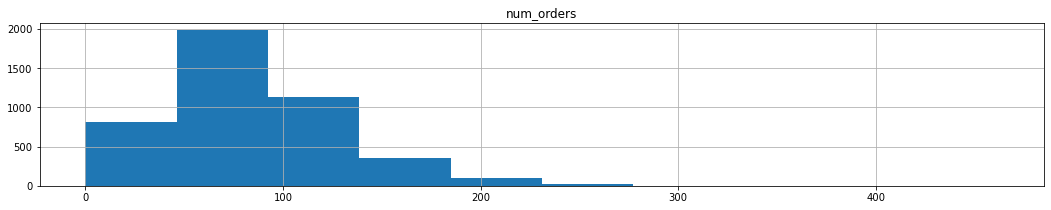

In [18]:
data.hist();

In [19]:
df = pd.DataFrame()
df['num_orders'] = data.num_orders.values
df['dayofweek'] = data.index.dayofweek
df['month'] = data.index.month

In [20]:
#The day of the week with Monday=0, Sunday=6.
def day_to_day(col):
    
    if col == 0:
        return 'monday'
    elif col == 1:
        return 'tuesday'
    elif col == 2:
        return 'wednesday'
    elif col == 3:
        return 'thursday'
    elif col == 4:
        return 'friday'
    elif col == 5:
        return 'saturday'
    elif col == 6:
        return 'sunday'


In [21]:
df['week_day'] = df['dayofweek'].apply(day_to_day)

In [22]:
df = df.sort_values('month')
df

,num_orders,dayofweek,month,week_day
0,124,3,3,thursday
490,57,2,3,wednesday
491,71,2,3,wednesday
492,37,2,3,wednesday
493,64,2,3,wednesday
...,...,...,...,...
3922,140,5,8,saturday
3923,81,5,8,saturday
3924,63,5,8,saturday
3915,171,5,8,saturday


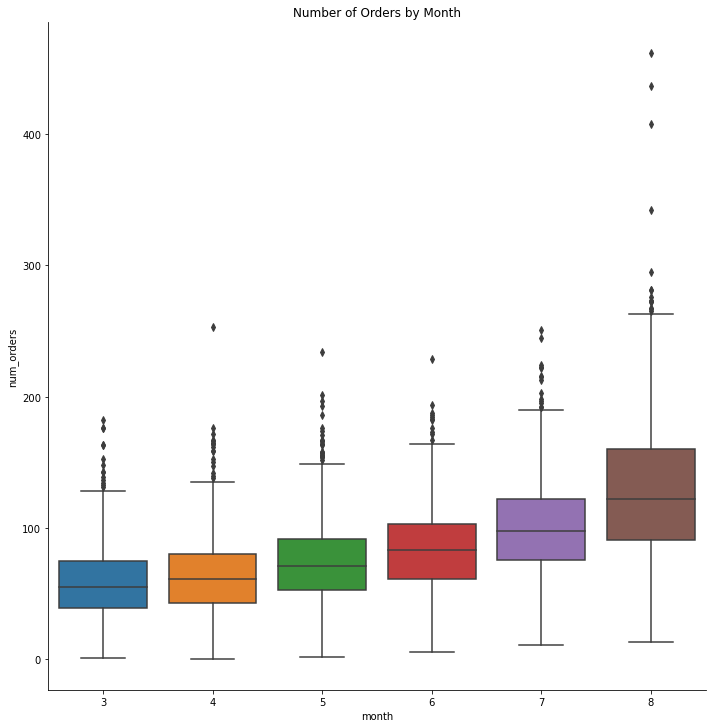

In [23]:
sns.catplot(x="month", y="num_orders", kind="box", data=df, size = 10)
plt.title("Number of Orders by Month")
plt.show()

In [24]:
df = df.sort_values('dayofweek')
df

,num_orders,dayofweek,month,week_day
955,62,0,4,monday
275,84,0,3,monday
276,45,0,3,monday
3628,140,0,7,monday
3629,119,0,7,monday
...,...,...,...,...
2931,89,6,7,sunday
2930,100,6,7,sunday
2929,84,6,7,sunday
1255,9,6,4,sunday


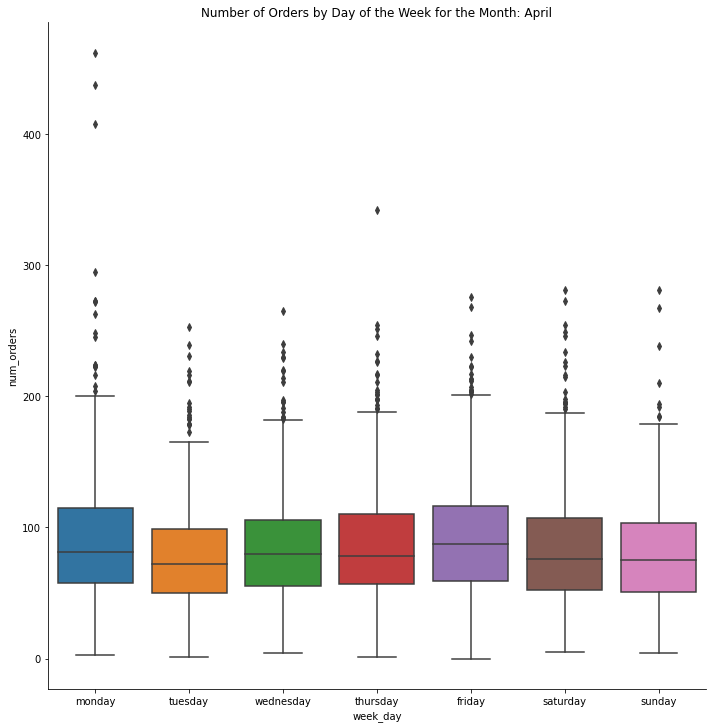

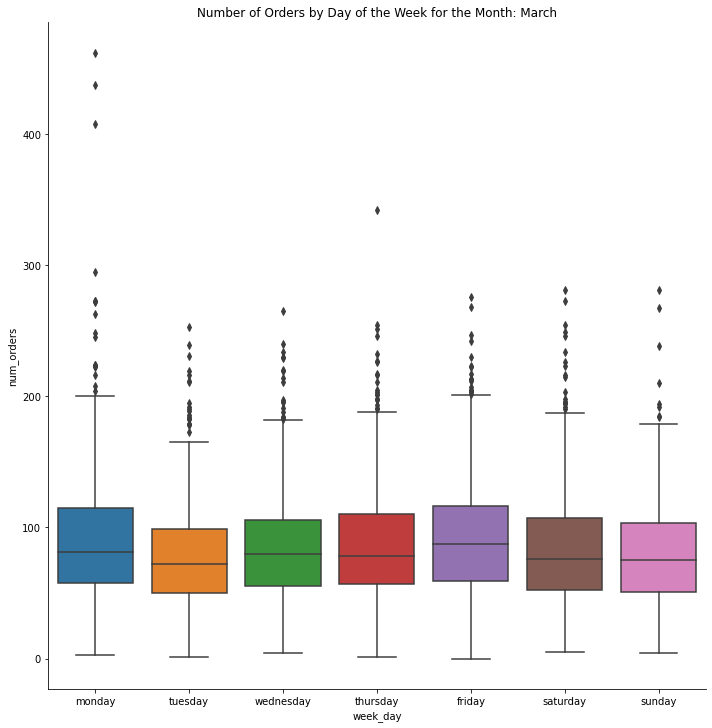

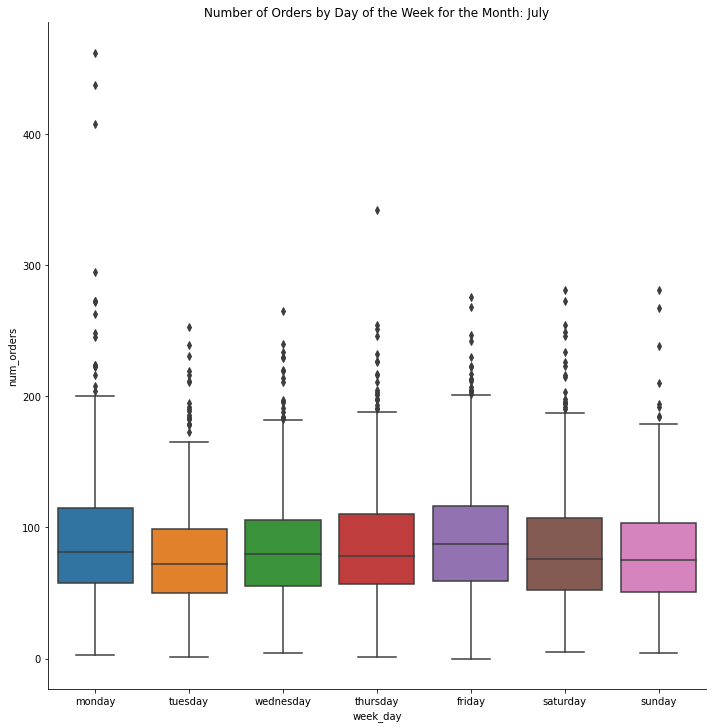

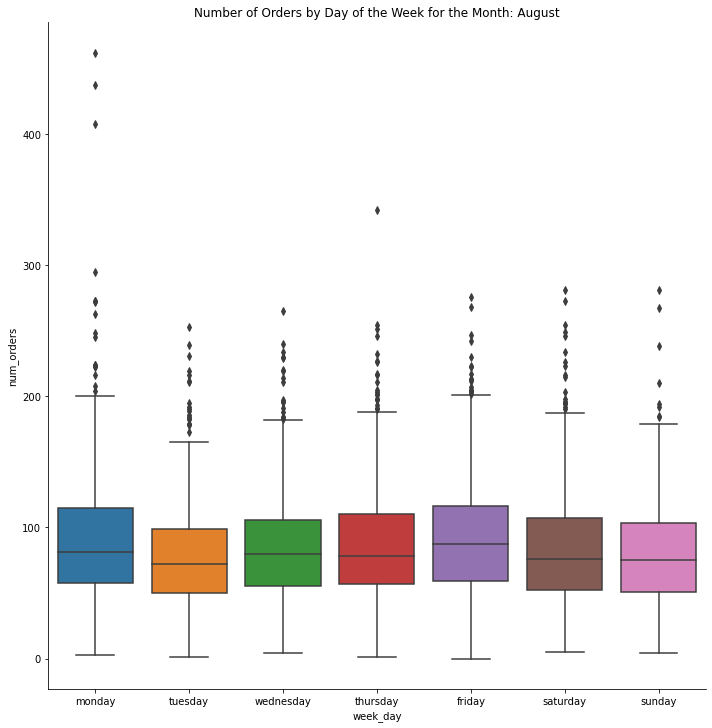

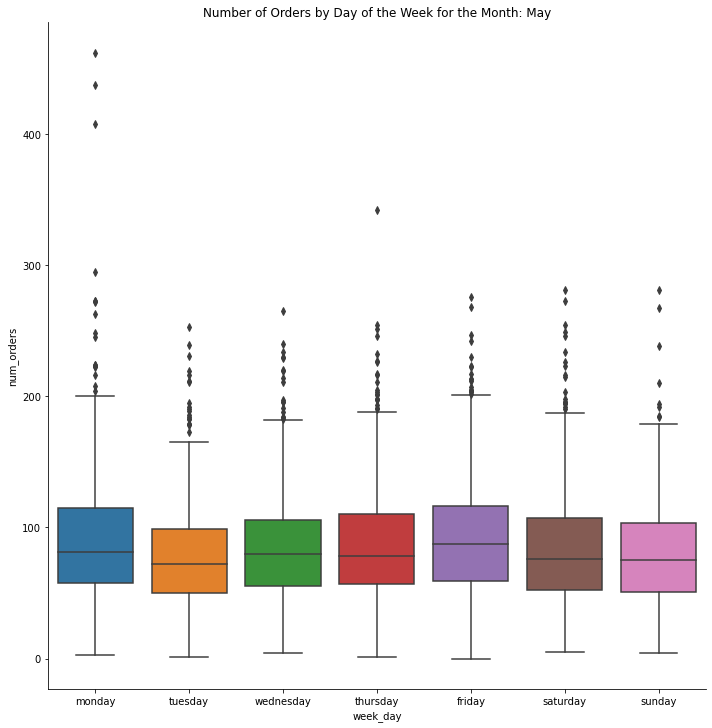

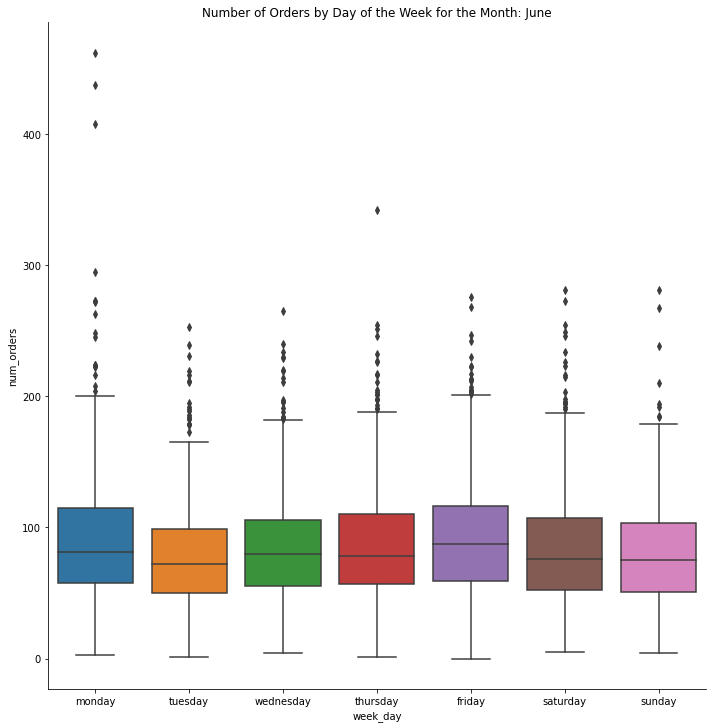

In [25]:
for month in list(df.month.unique()):
    sns.catplot(x="week_day", y="num_orders", kind="box", data=df, size = 10)
    plt.title("Number of Orders by Day of the Week for the Month: " +calendar.month_name[month])
    plt.show()

#### moving avergae smoothing

In [26]:
rolling = data.rolling(window=3)
rolling_mean = rolling.mean()

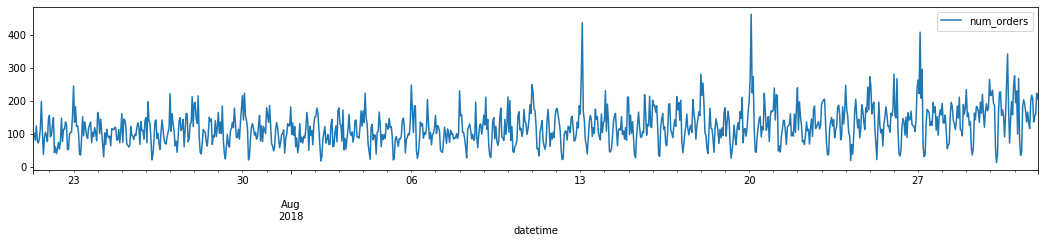

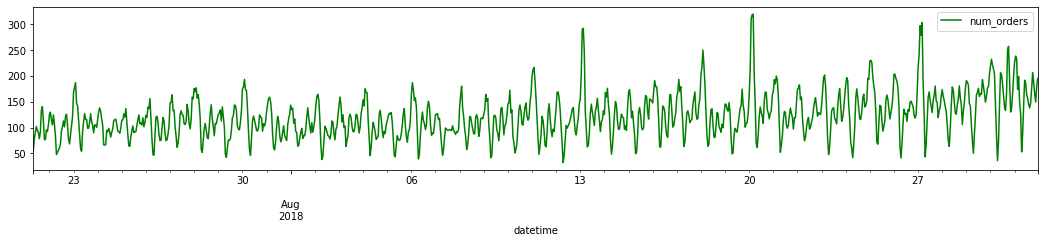

In [27]:
data[-1000:].plot()
rolling_mean[-1000:].plot(color='green');

#### Lags plot

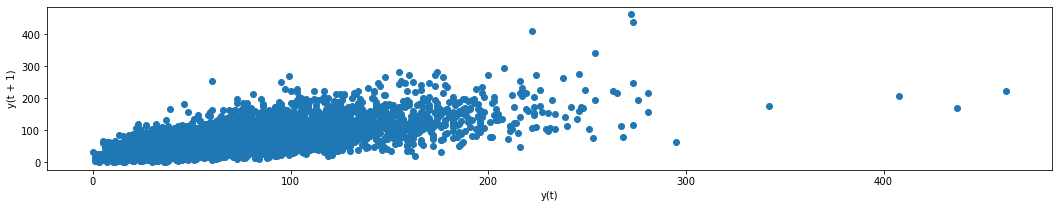

In [28]:
pd.plotting.lag_plot(data);

In [29]:
#note:there are ouliers above 300 that need to be removed
data_b =  data.query('num_orders <300')

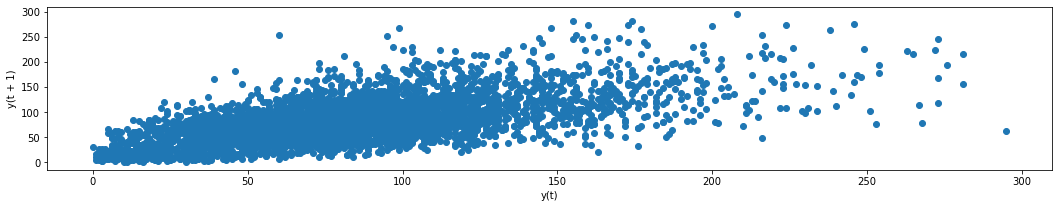

In [30]:
pd.plotting.lag_plot(data_b);

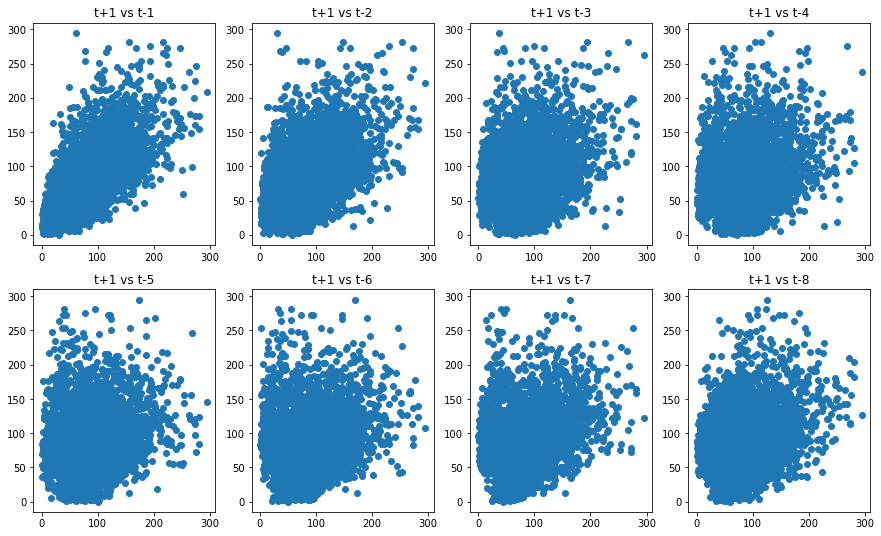

In [31]:
#creat multiple lag scatter plots
values = pd.DataFrame(data_b.values)
lags =8
columns = [values]

for i in range(1,(lags+1)):
    columns.append(values.shift(i))

df = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags+1)):
    columns.append('t-' + str(i))

df.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags+1)):
    ax = plt.subplot(240+i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)

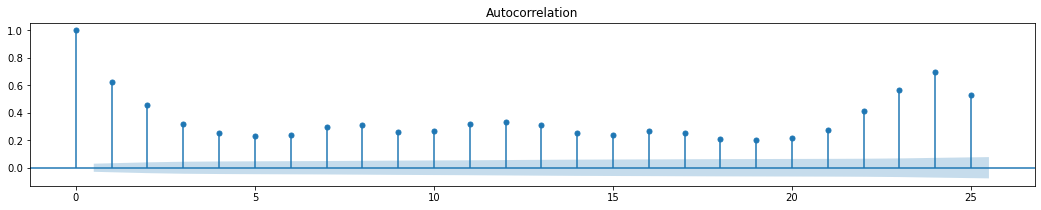

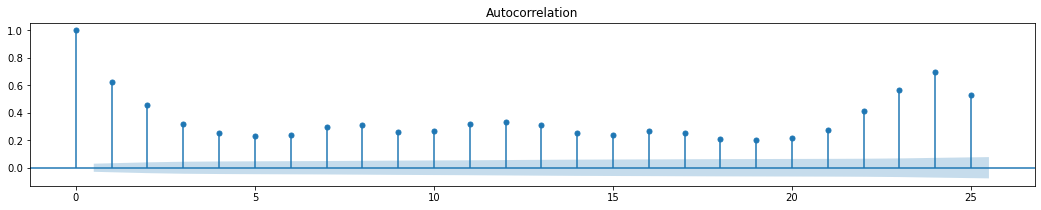

In [32]:
plot_acf(data_b, lags=25)

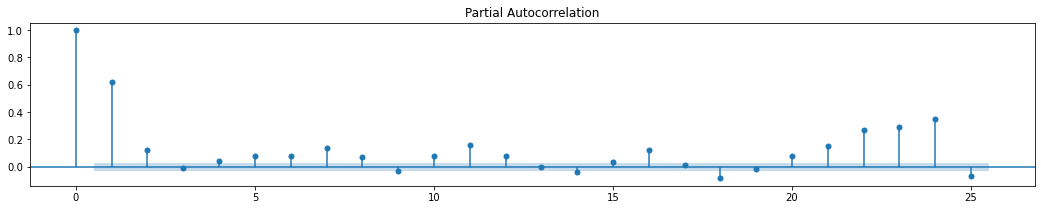

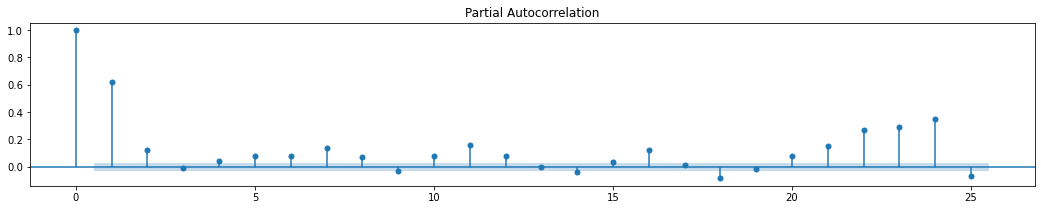

In [33]:
plot_pacf(data_b, lags=25)

<div style="border:solid black 2px; padding: 20px"> <b>Note:</b><br>

The data is non-stationary, meaning we will need to change it to stationary to train the ML models. 
the decompose and box plots show that the peak month is august and, Monday and Friday are the busiest days of the week.
Moreover, there were some outliers above 300 orders that had been removed. 
In addition, the lag plot, the acf, and pacf show that there are is a correlation in the most previous lags but there is still some correlation in the lags that are farther down the line. 
We will use this conclusion in building the features for the models. 

## Train different models with various hyperparameters<a class="anchor" id="train"></a>


Our goal is to reach RMSE metric on the test set not more than 48.

### Features engineering <a class="anchor" id="engineering"></a>

In [34]:
#Making the data stationary
data_diff = data_b - data_b.shift()

<AxesSubplot:xlabel='datetime'>

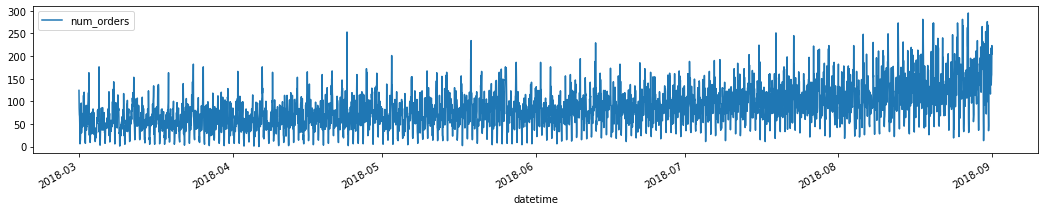

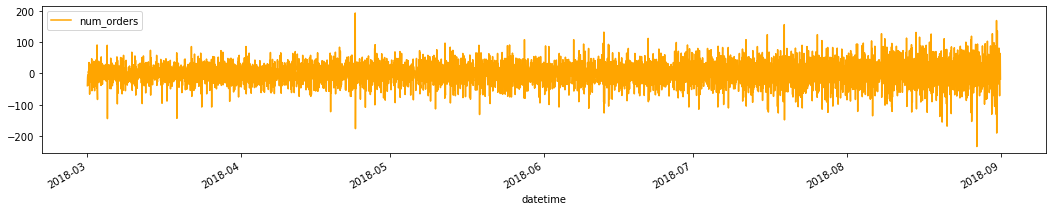

In [37]:
data_b.plot();
data_diff.plot(color='orange')

In [38]:
df_ml = data_diff.copy()

In [39]:
#function tomake feature based on EDA
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

    data['rolling_max'] = data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).min()
    

    data['rolling_min'] = data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).max()
    return data

In [40]:
make_features(df_ml,24,24)
df_ml

,num_orders,month,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_max,rolling_min
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.00,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.00,3,2,3,-39.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.00,3,3,3,-14.00,-39.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.00,3,4,3,-5.00,-14.00,-39.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.00,8,19,4,-10.00,20.00,81.00,-17.00,-33.00,30.00,...,-82.00,30.00,88.00,-40.00,56.00,70.00,-105.00,169.00,-190.00,169.00
2018-08-31 20:00:00,18.00,8,20,4,-71.00,-10.00,20.00,81.00,-17.00,-33.00,...,36.00,-82.00,30.00,88.00,-40.00,56.00,70.00,169.00,-190.00,169.00
2018-08-31 21:00:00,5.00,8,21,4,18.00,-71.00,-10.00,20.00,81.00,-17.00,...,-131.00,36.00,-82.00,30.00,88.00,-40.00,56.00,169.00,-190.00,169.00


In [41]:
#changing the target back
df_ml['num_orders']=data_b['num_orders']

In [44]:
df_ml.head()

,num_orders,month,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_max,rolling_min
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,3,-39.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,-14.00,-39.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,3,-5.00,-14.00,-39.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#checking missing values
report = df_ml.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_ml.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm')

,missing_values,% of total
rolling_min,25,0.010000
rolling_max,25,0.010000
rolling_mean,25,0.010000
lag_24,25,0.010000
lag_23,24,0.010000
lag_22,23,0.010000
lag_21,22,0.000000
lag_20,21,0.000000
lag_19,20,0.000000
lag_18,19,0.000000


In [46]:
#droping na values
df_ml.dropna(inplace=True)

In [47]:
report = df_ml.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_ml.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm')

,missing_values,% of total
num_orders,0,0.000000
lag_13,0,0.000000
rolling_max,0,0.000000
rolling_mean,0,0.000000
lag_24,0,0.000000
lag_23,0,0.000000
lag_22,0,0.000000
lag_21,0,0.000000
lag_20,0,0.000000
lag_19,0,0.000000


### Split the data <a class="anchor" id="split"></a>

In [163]:
#Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.

In [48]:
#the test sample should be 10% of the initial dataset.
train, test = train_test_split(df_ml, shuffle=False, test_size=0.1)


In [49]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

### Scaling the features<a class="anchor" id="scaling"></a>

In [51]:
scaler = MinMaxScaler()
train_scaled_features= pd.DataFrame(scaler.fit_transform(features_train))
test_scaled_features=pd.DataFrame(scaler.transform(features_test))

### Training different models <a class="anchor" id="models"></a>

#### Linear Regression  <a class="anchor" id="linearregression"></a>

In [52]:
model = LinearRegression()
model.fit(train_scaled_features, target_train)
pred_train = model.predict(train_scaled_features)
pred_test = model.predict(test_scaled_features)
print('RMSE on train:', math.sqrt(mean_squared_error(target_train, pred_train)))
print('RMSE on test:', math.sqrt(mean_squared_error(target_test, pred_test)))

RMSE on train: 26.215312488660174
RMSE on test: 49.60617965291603


#### Random Forest Regressor<a class="anchor" id="randomforest"></a>

In [53]:
#Create function to train and fit models using GridSearchCV
def train_fit_score(model, params, name,scoring):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=scoring, verbose=0, refit=True)
    model.fit(train_scaled_features, target_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [54]:
%%time
#Create Random Forest Regressor
RandomForest = train_fit_score(RandomForestRegressor(random_state=12345), 
                       {'n_estimators' : range(150, 250, 25),
                        'max_depth' : range(45, 100, 10),
                        }, 'Random Forest',scoring='neg_root_mean_squared_error')

Wall time: 12min 25s


In [55]:

print(list(RandomForest['Best Params']))

[{'max_depth': 45, 'n_estimators': 200}]


In [68]:
model = RandomForestRegressor(random_state=12345, n_estimators=200,max_depth=45)
model_random_forest = model.fit(train_scaled_features, target_train)
predictions_train = model.predict(train_scaled_features)
predictions_test = model.predict(test_scaled_features)
print('RMSE on train:',math.sqrt(mean_squared_error(target_train, predictions_train)))
print('RMSE on test:', math.sqrt(mean_squared_error(target_test, predictions_test)))

RMSE on train: 8.360591362621001
RMSE on test: 48.16066022293859


In [78]:
RandomForest

,Estimator,Best Score,Best Params
0,Random Forest,26.38,"{'max_depth': 45, 'n_estimators': 200}"


### Catboost regressor<a class="anchor" id="Catboost"></a>

In [57]:
#splitting the train set to validation set for catboost and LightGBM
train_df, valid_df = train_test_split(train, test_size=0.1, random_state=12345)

In [58]:
target_train = train_df['num_orders']
features_train = train_df.drop('num_orders', axis=1)
target_valid = valid_df['num_orders']
features_valid  = valid_df.drop('num_orders', axis=1)

In [59]:
scaler = MinMaxScaler()
train_scaled_features= pd.DataFrame(scaler.fit_transform(features_train))
valid_scaled_features=pd.DataFrame(scaler.transform(features_valid))

In [71]:
%%time
#Training Catboost regressor
#seting an empthy data frame
Catboost_parameters = pd.DataFrame()
#lists for dataframe
cb_score_train = []
cb_score_valid = []
estimators = []
depths = []
#iteration through different parameters to find the best RandomForestRegressor parameters
for n in range(50,250, 50):
    for depth in range(0, 20 ,4):
        model=cb.CatBoostRegressor(max_depth=depth, iterations=n,loss_function= "RMSE",verbose= 10)
        model.fit(train_scaled_features, target_train)
        y_train_pred = model.predict(train_scaled_features)
        y_val_pred = model.predict(valid_scaled_features)
        train_RMSE = (mean_squared_error(target_train, y_train_pred))**0.5
        validation_RMSE = (mean_squared_error(target_valid, y_val_pred))**0.5
        
        cb_score_train.append(train_RMSE)
        cb_score_valid.append(validation_RMSE)
        estimators.append(n)
        depths.append(depth)
Catboost_parameters['iterations'] = estimators
Catboost_parameters['depths']=depths
Catboost_parameters['RMSE_score_train']=cb_score_train
Catboost_parameters['RMSE_score_valid']=cb_score_valid

Learning rate set to 0.5
0:	learn: 37.9878057	total: 579us	remaining: 28.4ms
10:	learn: 37.9878057	total: 5.21ms	remaining: 18.5ms
20:	learn: 37.9878057	total: 10.4ms	remaining: 14.4ms
30:	learn: 37.9878057	total: 16.3ms	remaining: 10ms
40:	learn: 37.9878057	total: 22.5ms	remaining: 4.94ms
49:	learn: 37.9878057	total: 27.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 30.7703244	total: 3.19ms	remaining: 156ms
10:	learn: 23.0184006	total: 28.5ms	remaining: 101ms
20:	learn: 21.5362801	total: 48.8ms	remaining: 67.3ms
30:	learn: 20.2260926	total: 67.5ms	remaining: 41.4ms
40:	learn: 19.3564927	total: 84.9ms	remaining: 18.6ms
49:	learn: 18.7368764	total: 106ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 30.2243384	total: 6.04ms	remaining: 296ms
10:	learn: 19.5997435	total: 58.2ms	remaining: 206ms
20:	learn: 16.6435865	total: 108ms	remaining: 150ms
30:	learn: 14.0666291	total: 158ms	remaining: 97ms
40:	learn: 11.9988701	total: 211ms	remaining: 46.3ms
49:	learn: 10.5165221	total: 2

In [72]:
Catboost_parameters[Catboost_parameters['RMSE_score_valid'] == Catboost_parameters.RMSE_score_valid.min()]

,iterations,depths,RMSE_score_train,RMSE_score_valid
11,150,4,16.90,23.54


In [73]:
%%time

#Catboost Regressor
cb_model = cb.CatBoostRegressor(max_depth=4, iterations=150,loss_function= "RMSE",verbose= 10)
cb_model.fit(train_scaled_features, target_train)
cb_y_val_test = cb_model.predict(test_scaled_features)
cb_test_RMSE = (mean_squared_error(target_test, cb_y_val_test))**0.5
print('The RMSE for Catboost Regressor is:',round(cb_test_RMSE,2))

Learning rate set to 0.23389
0:	learn: 34.2126174	total: 2.13ms	remaining: 317ms
10:	learn: 25.1018287	total: 17.9ms	remaining: 227ms
20:	learn: 23.2348632	total: 31.4ms	remaining: 193ms
30:	learn: 22.1153349	total: 45.2ms	remaining: 173ms
40:	learn: 21.3291720	total: 56.1ms	remaining: 149ms
50:	learn: 20.7396075	total: 66.6ms	remaining: 129ms
60:	learn: 20.2244316	total: 78ms	remaining: 114ms
70:	learn: 19.7656489	total: 88.9ms	remaining: 99ms
80:	learn: 19.3275238	total: 104ms	remaining: 88.3ms
90:	learn: 18.8449189	total: 121ms	remaining: 78.4ms
100:	learn: 18.4988404	total: 137ms	remaining: 66.4ms
110:	learn: 18.1605928	total: 151ms	remaining: 52.9ms
120:	learn: 17.8525795	total: 162ms	remaining: 38.8ms
130:	learn: 17.4832790	total: 172ms	remaining: 25ms
140:	learn: 17.1362068	total: 183ms	remaining: 11.7ms
149:	learn: 16.8995914	total: 193ms	remaining: 0us
The RMSE for Catboost Regressor is: 46.81
Wall time: 247 ms


#### LightGBM Regressor  <a class="anchor" id="LightGBM"></a>

In [74]:
%%time
#seting an empthy data frame
lgm_parameters = pd.DataFrame()
#lists for dataframe
lgm_score_train = []
lgm_score_valid = []
estimators = []
depths = []
num_leaves = []
#iteration through different parameters to find the best RandomForestRegressor parameters
for n in range(10,200, 10):
    for leave in range(10,100, 10):
        for depth in range(10, 200 ,10):
            model=lgb.LGBMRegressor(boosting_type='gbdt', max_depth= depth, n_estimators=n, num_leaves= leave)
            model.fit(train_scaled_features, target_train)
            y_train_pred = model.predict(train_scaled_features)
            y_val_pred = model.predict(valid_scaled_features)
            train_RMSE = (mean_squared_error(target_train, y_train_pred))**0.5
            validation_RMSE = (mean_squared_error(target_valid, y_val_pred))**0.5

            lgm_score_train.append(train_MAE)
            lgm_score_valid.append(validation_RMSE)
            num_leaves.append(leave)
            estimators.append(n)
            depths.append(depth)
            
lgm_parameters['n_estimators'] = estimators
lgm_parameters['num_leaves']=num_leaves
lgm_parameters['depths']=depths
lgm_parameters['train_RMSE']=lgm_score_train
lgm_parameters['RMSE_score_valid']=lgm_score_valid

Wall time: 15min 32s


In [75]:
lgm_parameters[lgm_parameters['RMSE_score_valid'] == lgm_parameters.RMSE_score_valid.min()]

,n_estimators,num_leaves,depths,train_RMSE,RMSE_score_valid
1978,120,60,30,0.01,22.09
1979,120,60,40,0.01,22.09
1980,120,60,50,0.01,22.09
1981,120,60,60,0.01,22.09
1982,120,60,70,0.01,22.09
1983,120,60,80,0.01,22.09
1984,120,60,90,0.01,22.09
1985,120,60,100,0.01,22.09
1986,120,60,110,0.01,22.09
1987,120,60,120,0.01,22.09


In [76]:
%%time

#LightGBM Regressor
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth= 30, n_estimators=120,num_leaves=60)
lgb_model.fit(train_scaled_features, target_train)
lgb_y_val_pred = lgb_model.predict(test_scaled_features)
lgb_test_RMSE = (mean_squared_error(target_test, lgb_y_val_pred))**0.5
print('The RMSE for LightGBM Regressor is:',round(lgb_test_RMSE,2))

The RMSE for LightGBM Regressor is: 45.87
Wall time: 103 ms


<div style="border:solid black 2px; padding: 20px"> <b>Note:</b><br>
The model with the best result is LightGBM Regressor with RMSE of 45.87

## Conclusion<a class="anchor" id="conclusion"></a>


In this project, I've shown how to predict the number of taxi orders m for the next hour base on time series and using different models with different parameter tuning. 
The best model is the LightGBM Regressor,  with the lowest RMSE of 45.87. 
To reach this result, there were a lot of features created and processing which were based on stationary data. 
To solve the original data, we needed to use the original data for the target.
In the end, the goal of the project - The RMSE metric on the test set should not be more than 48 has been achieved. 